# Structured sparsity in high-dimensional data

This notebook illustrates the point of using structured sparsity in high-dimensional data.

It is the basis of my talk at dotAI on May 28, 2018. 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
prop_cycle = plt.rcParams['axes.prop_cycle']
def_colors = prop_cycle.by_key()['color']

In [3]:
plt.rc('font', **{'size': 16})

In the StructuredSparsityDataGeneration.ipynb notebook, I have simulated data with 1000 features and only 150 observations.

The features are binary (as motivated by GWAS data).

I am also assuming a network structure on the features, captured by the adjacency matrix W. The network is built as a collection of fully connected subnetworks of 10 features, each connected to the next. One module is causal, meaning that the outcome y of interest is generated as a linear combination of the features of that module.

In [4]:
num_feats = 1000
num_obsvs = 150

mod_size = 10

num_causl = 10

## Load generated data

In [5]:
data_rep = 'data/struct_spars'
X_fname = '%s/X.data' % data_rep
y_fname = '%s/y.data' % data_rep
W_fname = '%s/W.data' % data_rep
causl_fname = '%s/causl.data' % data_rep
wghts_fname = '%s/w_causl.data' % data_rep

In [6]:
X = np.loadtxt(X_fname, dtype='int')
y = np.loadtxt(y_fname)
W = np.loadtxt(W_fname)
causl = list(np.loadtxt(causl_fname, dtype='int'))
w_causl = np.loadtxt(wghts_fname)

## Train-test split

In [7]:
from sklearn import model_selection

In [8]:
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y, test_size=0.3, random_state=17)

### True model 

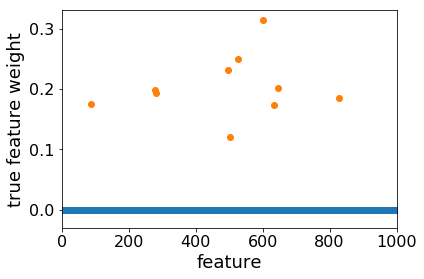

In [9]:
fig = plt.figure(figsize(6, 4))

plt.scatter(range(num_feats), # x = SNP position
            np.zeros(shape=(num_feats, ))) # weight = 0 

# Plot the causal SNPs in red
plt.scatter(causl, 
            w_causl)

plt.xlabel("feature", fontsize=18)
plt.ylabel("true feature weight", fontsize=18)
plt.xlim([0, num_feats])

plt.savefig('structured_sparsity/causl_weight.png', bbox_inches='tight')

In [10]:
y_pred = np.dot(X_test[:, causl], w_causl)
print y_pred.shape

(45,)


In [11]:
from sklearn import metrics

In [12]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

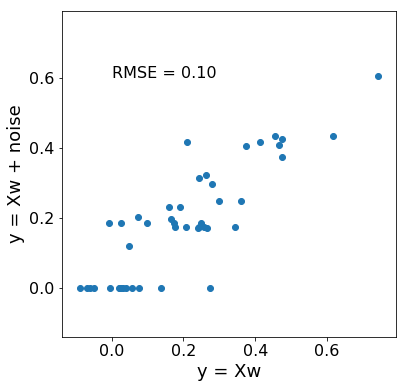

In [13]:
fig = plt.figure(figsize(6, 6))

plt.scatter(y_test, y_pred)

plt.xlabel("y = Xw", fontsize=18)
plt.ylabel("y = Xw + noise", fontsize=18)
plt.xlim([np.min(y_test)-0.05, np.max(y_test)+0.05])
plt.ylim([np.min(y_test)-0.05, np.max(y_test)+0.05])

plt.text(0, 0.6, 'RMSE = %.2f' % rmse)

plt.savefig('structured_sparsity/true_pred.png', bbox_inches='tight')

## T-test

In [14]:
import statsmodels.api as sm

In [15]:
pvalues = []
for feat_idx in range(num_feats):
    myX = X_train[:, feat_idx]
    myX = sm.add_constant(myX)
    est = sm.regression.linear_model.OLS(y_train, myX)
    est2 = est.fit()
    pvalues.append(est2.pvalues[1])
pvalues = np.array(pvalues)

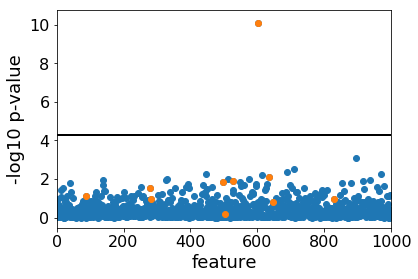

In [16]:
fig = plt.figure(figsize(6, 4))

plt.scatter(range(num_feats), # x = SNP position
            -np.log10(pvalues)) # y = -log10 p-value 

# Plot the causal SNPs in red
plt.scatter(causl, 
            -np.log10(pvalues[causl]),
            color=def_colors[1])

# significance threshold according to Bonferroni correction
t = -np.log10(0.05/num_feats)
plt.plot([0, num_feats], [t, t], lw=2, c='k')

plt.xlabel("feature", fontsize=18)
plt.ylabel("-log10 p-value", fontsize=18)
plt.xlim([0, num_feats])

plt.savefig('structured_sparsity/t_test.png', bbox_inches='tight')

Only one causal feature was identified as significant. Even increasing the significance level (or using a less stringent correction for multiple hypothesis testing) would not rescue the 9 other causal features.

### Validation 

What is the significance of the true SNPs on the test set?

In [17]:
pvalues = []
for feat_idx in causl:
    myX = X_test[:, feat_idx]
    myX = sm.add_constant(myX)
    est = sm.regression.linear_model.OLS(y_test, myX)
    est2 = est.fit()
    pvalues.append(est2.pvalues[1])
pvalues = np.array(pvalues)

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/home/chagaz/.local/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/chagaz/.local/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/chagaz/.local/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


(0, 1000)

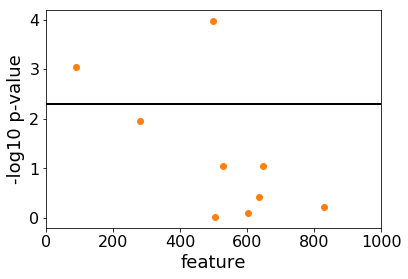

In [18]:
fig = plt.figure(figsize(6, 4))

plt.scatter(causl, 
            -np.log10(pvalues),
            color=def_colors[1])

# significance threshold according to Bonferroni correction
t = -np.log10(0.05/len(causl))
plt.plot([0, num_feats], [t, t], lw=2, c='k')

plt.xlabel("feature", fontsize=18)
plt.ylabel("-log10 p-value", fontsize=18)
plt.xlim([0, num_feats])

#plt.savefig('manhattan.png', bbox_inches='tight')

## Linear regression 

In [19]:
from sklearn import linear_model

In [20]:
model = linear_model.LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

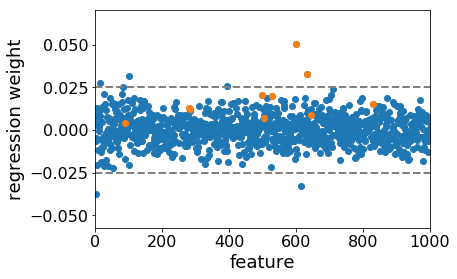

In [21]:
fig = plt.figure(figsize(6, 4))

plt.scatter(range(num_feats), # x = SNP position
            model.coef_) # y = regression weights

plt.scatter(causl, 
            model.coef_[causl],
            color=def_colors[1])

plt.plot([0, num_feats], [0.025, 0.025], lw=2, c='grey', ls='--')
plt.plot([0, num_feats], [-0.025, -0.025], lw=2, c='grey', ls='--')


plt.xlabel("feature", fontsize=18)
plt.ylabel("regression weight", fontsize=18)
plt.xlim([0, num_feats])

plt.savefig('structured_sparsity/linreg_weights.png', bbox_inches='tight')

The feautres that have the largest weight (in magnitude) are not necessarily the causal ones. Some causal features have a very low weight.

The dashed lines at +/- 0.025 have been chosen arbitrarily.

### Validation

In [22]:
ypred = model.predict(X_test)

In [23]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

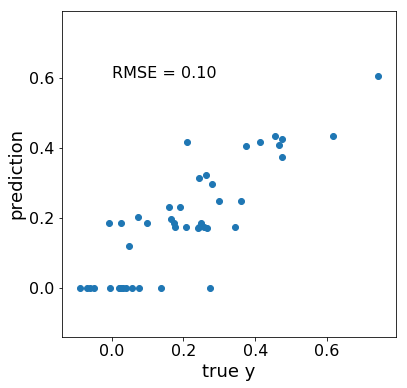

In [24]:
fig = plt.figure(figsize(6, 6))

plt.scatter(y_test, y_pred)

plt.xlabel("true y", fontsize=18)
plt.ylabel("prediction", fontsize=18)
plt.xlim([np.min(y_test)-0.05, np.max(y_test)+0.05])
plt.ylim([np.min(y_test)-0.05, np.max(y_test)+0.05])

plt.text(0, 0.6, 'RMSE = %.2f' % rmse)

plt.savefig('structured_sparsity/linreg_pred.png', bbox_inches='tight')

## Lasso 

In [25]:
model = linear_model.Lasso(fit_intercept=True, alpha=0.005)
model.fit(X_train, y_train)

Lasso(alpha=0.005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

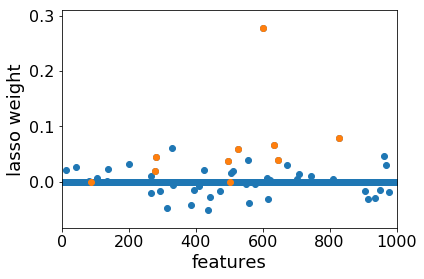

In [26]:
fig = plt.figure(figsize(6, 4))

plt.scatter(range(num_feats), # x = SNP position
            model.coef_) # y = regression weight

plt.scatter(causl, 
            model.coef_[causl],
            color=def_colors[1])

plt.xlabel("features", fontsize=18)
plt.ylabel("lasso weight", fontsize=18)
plt.xlim([0, num_feats])

plt.savefig('structured_sparsity/lasso_weights.png', bbox_inches='tight')

The solution is sparse, but many non-causal features have non-zero weights and several causal features have a weight of 0.

If you increase lambda, you'll lose  more causal features.

### Validation

In [27]:
y_pred = model.predict(X_test)

In [28]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

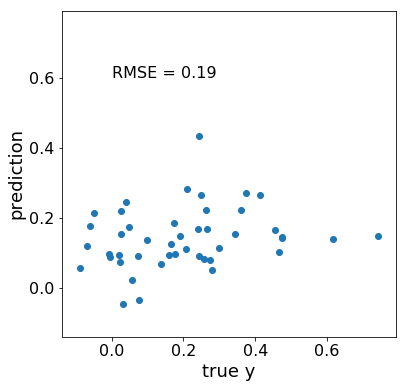

In [29]:
fig = plt.figure(figsize(6, 6))

plt.scatter(y_test, y_pred)

plt.xlabel("true y", fontsize=18)
plt.ylabel("prediction", fontsize=18)
plt.xlim([np.min(y_test)-0.05, np.max(y_test)+0.05])
plt.ylim([np.min(y_test)-0.05, np.max(y_test)+0.05])

plt.text(0, 0.6, 'RMSE = %.2f' % rmse)

plt.savefig('structured_sparsity/lasso_pred.png', bbox_inches='tight')

The predictivity has slightly improved.

## Network-Connected Lasso 

This method is developed in https://academic.oup.com/bioinformatics/article/24/9/1175/206444

As detailed in the paper, this can be reformulated so as to be solved as a Lasso problem.

### Laplacian

In [30]:
degree = np.sum(W, axis=0)
L = np.diag(degree) - W

# spectral decomposition
evals, evecs = np.linalg.eigh(L)

# correct for numerical errors: 
# eigenvalues of 0 might be computed as small negative numbers
evals = np.maximum(0, evals)

### New variables

In [31]:
S = np.dot(evecs, np.diag(evals))

In [32]:
y_new = np.hstack((y_train, np.zeros((num_feats, ))))

In [33]:
l1 = 0.001
l2 = 10.

In [34]:
gamma = l1/(np.sqrt(l2+1))

In [35]:
X_new = 1/(np.sqrt(l2+1)) * np.vstack((X_train, np.sqrt(l2)*S.T))

### ncLasso

In [36]:
model = linear_model.Lasso(fit_intercept=True, alpha=gamma)
model.fit(X_new, y_new)

Lasso(alpha=0.00030151134457776364, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

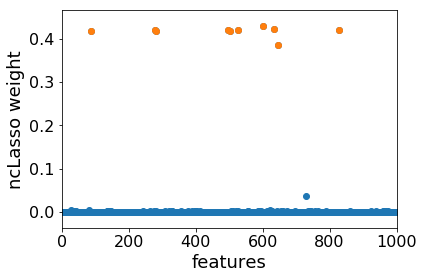

In [37]:
fig = plt.figure(figsize(6, 4))

plt.scatter(range(num_feats), # x = SNP position
            model.coef_) # y = -log10 p-value (the higher the more significant)

# Plot the causal SNPs in red
#plt.scatter(range(num_causl), 
#            -np.log10(pvalues[:num_causl]),
#            color='orange')
plt.scatter(causl, 
            model.coef_[causl],
            color=def_colors[1])

plt.xlabel("features", fontsize=18)
plt.ylabel("ncLasso weight", fontsize=18)
plt.xlim([0, num_feats])

plt.savefig('structured_sparsity/nclasso_weights.png', bbox_inches='tight')

The algorithm is much better at identifying causal features!

### Validation

In [38]:
y_test_new = np.hstack((y_test, np.zeros((num_feats, ))))
X_test_new = 1/(np.sqrt(l2+1)) * np.vstack((X_test, np.sqrt(l2)*S.T))

In [39]:
y_pred = model.predict(X_test_new)[:y_test.shape[0]]

In [40]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

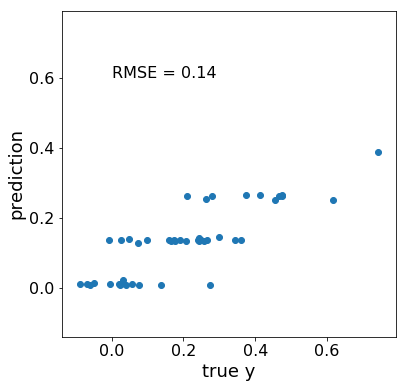

In [41]:
fig = plt.figure(figsize(6, 6))

plt.scatter(y_test, y_pred)

plt.xlabel("true y", fontsize=18)
plt.ylabel("prediction", fontsize=18)
plt.xlim([np.min(y_test)-0.05, np.max(y_test)+0.05])
plt.ylim([np.min(y_test)-0.05, np.max(y_test)+0.05])

plt.text(0, 0.6, 'RMSE = %.2f' % rmse)

plt.savefig('structured_sparsity/nclasso_pred.png', bbox_inches='tight')

The performance improved noticeably.

## sfan

In [42]:
cd code/

/home/chagaz/repositories/sfan/code


In [43]:
import tempfile

### Create dimacs file from adjacency matrix

In [44]:
def convert_W_to_dimacs(W, dimacs_fname):
    num_edges = np.sum(W)
    print "Considering %d edges" % num_edges
    
    num_features = W.shape[0]
    
    with open(dimacs_fname, 'w') as g:
        g.write("p max %d %d\n" % (num_features, num_edges))        
        for u, v in zip(np.nonzero(W)[0], np.nonzero(W)[1]):
            g.write("a %d %d %d\n" % ((u+1), (v+1), int(W[u, v])))
        g.close()

In [45]:
w_fh, w_fname = tempfile.mkstemp(suffix='network.dimacs')

In [46]:
print w_fname

/tmp/tmpmdWOgFnetwork.dimacs


In [47]:
convert_W_to_dimacs(W, w_fname) 

Considering 9198 edges


### Create node weights file from t-test scores

In [48]:
def compute_node_weights(X, y, node_weights_fname):
    num_features = X.shape[1]
    
    with open(node_weights_fname, 'w') as g:
        for feat_idx in range(num_features):
            myX = X[:, feat_idx]
            myX = sm.add_constant(myX)
            est = sm.regression.linear_model.OLS(y, myX)
            est2 = est.fit()
            g.write("%.3e\n" % np.abs(est2.tvalues[1]))
        g.close()

In [49]:
c_fh, c_fname = tempfile.mkstemp(suffix='scores_0.txt')

In [50]:
print c_fname

/tmp/tmpPLI0yBscores_0.txt


In [51]:
compute_node_weights(X_train, y_train, c_fname)

### Run sfan

In [52]:
lbd = 5.
eps = 1.

In [53]:
vv = !python multitask_sfan.py -k 1 -w $w_fname -r $c_fname -l $lbd -e $eps
print vv

['# lambda 5.0', '# eta 1.0', '89 281 284 499 504 528 602 635 647 830 ', 'Task (1) computation time: 0.390866', 'Task average computation time: 0.390866', 'Standard deviation computation time: 0.0', 'Network building time: 0.409352', 'gt_maxflow computation time: 0.075563', 'Process time: 0.798302', '']


### Get selected features

In [54]:
selected = [(int(i)-1) for i in vv[2].split()]
print selected 

[88, 280, 283, 498, 503, 527, 601, 634, 646, 829]


### Plot selected features

In [55]:
cd ..

/home/chagaz/repositories/sfan


In [56]:
non_selected = [ix for ix in range(num_feats) if ix not in selected]

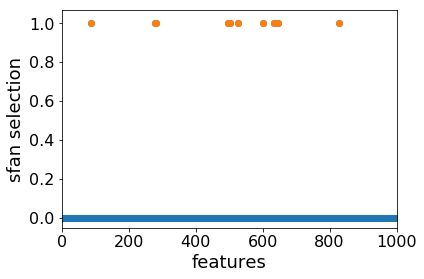

In [57]:
fig = plt.figure(figsize(6, 4))

plt.scatter(selected, # x = SNP position
            np.ones(shape=(len(selected), 1)),
           color=def_colors[0])
plt.scatter(non_selected, 
            np.zeros(shape=(len(non_selected), 1)),
           color=def_colors[0])
plt.scatter(causl, 
            np.ones(shape=(len(causl), )),
            color=def_colors[1])

plt.xlabel("features", fontsize=18)
plt.ylabel("sfan selection", fontsize=18)
plt.xlim([0, num_feats])

plt.savefig('structured_sparsity/sfan_selected.png', bbox_inches='tight')

sfan selected exactly the right features! 

### Validation

#### Create predictive model from the selected features only 

In [58]:
model = linear_model.LinearRegression(fit_intercept=True)
model.fit(X_train[:, selected], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [59]:
y_pred = model.predict(X_test[:, selected])

In [60]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

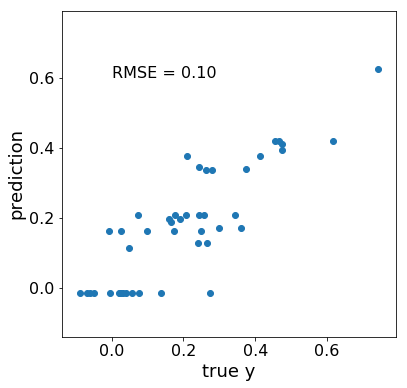

In [61]:
fig = plt.figure(figsize(6, 6))

plt.scatter(y_test, y_pred)

plt.xlabel("true y", fontsize=18)
plt.ylabel("prediction", fontsize=18)
plt.xlim([np.min(y_test)-0.05, np.max(y_test)+0.05])
plt.ylim([np.min(y_test)-0.05, np.max(y_test)+0.05])

plt.text(0, 0.6, 'RMSE = %.2f' % rmse)

plt.savefig('structured_sparsity/sfan_pred.png', bbox_inches='tight')

Once the correct features are selected, the linear regression can make good predictions.

## Clean up

In [62]:
import os
os.remove(c_fname)
os.remove(w_fname)